# Importing Libraries

In [314]:
import lasio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.metrics import r2_score
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import matplotlib

In [316]:
las = lasio.read(r"F:\Petrophysics Sabah Basin Malaysia\Petrophysical LAS (26-09-2025)\BULUH-1.LAS", engine='normal')
df = las.df()

In [317]:
df

,CALI_UM,DT_UM,DTS_UM,GR_UM,RHOB_UM,RT_UM,NPHI_UM,VSHL_UM,PHIA_UM,PHIE_UM,...,SWT_UM,GROSS_UM,NET_UM,PAY_UM,VCLB,VCLD,VHC,VLIME,VSAND,VWATER
DEPT,,,,,,,,,,,,,,,,,,,,,
1273.1496,NaN,NaN,NaN,9.1532,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1273.3020,NaN,NaN,NaN,7.2353,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1273.4544,NaN,NaN,NaN,8.0962,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1273.6068,NaN,NaN,NaN,9.3992,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1273.7592,NaN,NaN,NaN,10.2519,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271.5220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2271.6744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2271.8268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [320]:
df['VCLW'] = df['VCLD'] + df['VCLB']
df['SH'] = df['SWT_UM']-1

In [321]:
df['VP'] = 1 / (df['DT_UM'] * 3.28084 / 1e6)
df['VS'] = 1 / (df['DTS_UM'] * 3.28084 / 1e6)

# Density Modeling

In [325]:
def compute_matrix_density_log(df, volume_cols, density_values):

    # Validate densities exist
    for col in volume_cols:
        if col not in density_values:
            raise ValueError(f"Density value missing for mineral: {col}")

    # Mass-balance equation (vectorized)
    rho_matrix = sum(df[col] * density_values[col] for col in volume_cols)

    return rho_matrix

In [326]:
def compute_fluid_density_log(df, saturation_cols, fluid_densities):

    # Validate densities exist
    for col in saturation_cols:
        if col not in fluid_densities:
            raise ValueError(f"Fluid density missing for: {col}")

    # Mass-balance fluid density
    rho_fluid = sum(df[col] * fluid_densities[col] for col in saturation_cols)

    return rho_fluid

In [327]:
def compute_effective_density_fraction(df, phie_col="PHIE", rhof_col="RHOF", rhom_col="RHOM",
                                       out_col="RHOB", inplace=True):
    """
    Compute effective (bulk) density log assuming PHIE is already a fraction (0-1).

    rho_bulk = (1 - PHIE) * RHOM + PHIE * RHOF

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing log curves.
    phie_col : str
        Column name for effective porosity (PHIE) in fraction (0-1).
    rhof_col : str
        Column name for fluid density (RHOF) (g/cc).
    rhom_col : str
        Column name for matrix density (RHOM) (g/cc).
    out_col : str
        Name for output bulk density column (default "RHOB").
    inplace : bool
        If True, assign the result to df[out_col]. If False, only return the Series.

    Returns
    -------
    pandas.Series
        The computed bulk density log (g/cc). Also assigned into df if inplace=True.

    Raises
    ------
    KeyError
        If any of the specified columns are missing from df.
    ValueError
        If PHIE contains values outside [0, 1] after clipping check (will clip but warn).
    """

    # Validate presence of columns
    for col in (phie_col, rhof_col, rhom_col):
        if col not in df.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame")

    # Convert to float
    phie = df[phie_col].astype(float).copy()
    rhof = df[rhof_col].astype(float).copy()
    rhom = df[rhom_col].astype(float).copy()

    # Clip PHIE to [0,1] to avoid unphysical values (but keep user-informed)
    phie_clipped = phie.clip(lower=0.0, upper=1.0)
    if not phie.equals(phie_clipped):
        # small non-blocking info: values were outside [0,1] and clipped
        # we don't raise, only correct silently — change behavior if you prefer an error.
        phie = phie_clipped
    else:
        phie = phie_clipped

    # Vectorized bulk density calculation
    rho_bulk = (1.0 - phie) * rhom + phie * rhof

    if inplace:
        df[out_col] = rho_bulk

    return rho_bulk

In [351]:
volume_cols = ["VSAND", "VLIME", "VCLW"]
density_values = {
    "VSAND": 2.65,
    "VLIME": 2.71,
    "VCLW": 2.69
    
}

saturation_cols = ["SWT_UM", "SH"]
fluid_densities = {
    "SWT_UM": 1.0,     
    "SH": 0.2     
}

df["RHOF"] = compute_fluid_density_log(df, saturation_cols, fluid_densities)
df["RHOM"] = compute_matrix_density_log(df, volume_cols, density_values)
df["RHOB_EFF"] = compute_effective_density_fraction(df, phie_col="PHIA_UM",
                                                rhof_col="RHOF", rhom_col="RHOM",
                                                out_col="RHOB", inplace=True)


# Mineral Bulk Modulas

In [362]:
def compute_mineral_bulk_modulus(df, volume_cols, bulk_moduli):
    """
    Compute Voigt, Reuss, and Hill averages for bulk modulus of mineral mixture.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing volume fractions
    volume_cols : list
        List of column names for mineral volume fractions
    bulk_moduli : dict
        Dictionary mapping mineral column names to their bulk moduli (in GPa)
    
    Returns:
    --------
    tuple of three pandas.Series
        (K_voigt, K_reuss, K_hill)
    """
    
    # Validate bulk moduli exist
    for col in volume_cols:
        if col not in bulk_moduli:
            raise ValueError(f"Bulk modulus value missing for mineral: {col}")

    # Voigt average (upper bound): Weighted arithmetic mean
    K_voigt = sum(df[col] * bulk_moduli[col] for col in volume_cols)
    
    # Reuss average (lower bound): Weighted harmonic mean
    K_reuss = 1 / sum(df[col] / bulk_moduli[col] for col in volume_cols)
    
    # Hill average (VRH): Arithmetic mean of Voigt and Reuss
    K_hill = (K_voigt + K_reuss) / 2

    return K_voigt, K_reuss, K_hill

In [363]:
bulk_moduli = {
    "VSAND": 36.0,   # Quartz bulk modulus (GPa)
    "VLIME": 65.0,   # Silt/Feldspar bulk modulus (GPa)
    "VCLW": 15.0     # Clay bulk modulus (GPa)
}

volume_cols = ["VSAND", "VLIME", "VCLW"]

# Compute all three bulk moduli
df["K_VOIGT"], df["K_REUSS"], df["K_HILL"] = compute_mineral_bulk_modulus(df, volume_cols, bulk_moduli)

# Fluid Bulk Modulas

In [276]:
def compute_fluid_bulk_modulus(df, saturation_cols, fluid_bulk_moduli):
    """
    Compute fluid bulk modulus using Reuss average (harmonic mean).
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing fluid saturations
    saturation_cols : list
        List of column names for fluid saturations (should sum to 1)
    fluid_bulk_moduli : dict
        Dictionary mapping fluid column names to their bulk moduli (in GPa)
    
    Returns:
    --------
    pandas.Series
        Fluid bulk modulus (K_fl)
    """
    
    # Validate fluid bulk moduli exist
    for col in saturation_cols:
        if col not in fluid_bulk_moduli:
            raise ValueError(f"Fluid bulk modulus value missing for: {col}")

    # Reuss average (harmonic mean) for fluids: 1/K_fl = Σ(S_i / K_i)
    K_fl = 1 / sum(df[col] / fluid_bulk_moduli[col] for col in saturation_cols)

    return K_fl

In [365]:
fluid_bulk_moduli = {
    "SWT_UM": 2.2,   # Water bulk modulus (GPa) at reservoir conditions
    "SH": 0.03        # Gas bulk modulus (GPa) at reservoir conditions
}

saturation_cols = ["SWT_UM", "SH"]
df["K_FL"] = compute_fluid_bulk_modulus(df, saturation_cols, fluid_bulk_moduli)

# Mineral Shear Modulas

In [366]:
# Shear modulus computation
def compute_mineral_shear_modulus(df, volume_cols, shear_moduli):
    # Validate shear moduli exist
    for col in volume_cols:
        if col not in shear_moduli:
            raise ValueError(f"Shear modulus value missing for mineral: {col}")

    # Voigt average (upper bound): Weighted arithmetic mean
    G_voigt = sum(df[col] * shear_moduli[col] for col in volume_cols)
    
    # Reuss average (lower bound): Weighted harmonic mean
    G_reuss = 1 / sum(df[col] / shear_moduli[col] for col in volume_cols)
    
    # Hill average (VRH): Arithmetic mean of Voigt and Reuss
    G_hill = (G_voigt + G_reuss) / 2

    return G_voigt, G_reuss, G_hill


In [367]:
shear_moduli = {
    "VSAND": 45.0,   # GPa
    "VLIME": 48.0,   # GPa
    "VCLW": 10.0     # GPa
}

volume_cols = ["VSAND", "VLIME", "VCLW"]

df["G_VOIGT"], df["G_REUSS"], df["G_HILL"] = compute_mineral_shear_modulus(df, volume_cols, shear_moduli)

# Inverse Gasssman for KDRY

In [368]:
def compute_k_dry_inverse_gassman(df, phi_col, vp_col, vs_col, rho_col, K_min_col, K_fl_col):
    """
    Simple computation of K_dry with VS.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    phi_col : str
        Porosity column
    vp_col : str
        VP column in m/s
    vs_col : str
        VS column in m/s
    rho_col : str
        Density column in g/cc
    K_min_col : str
        Column name for mineral bulk modulus in GPa
    K_fl_col : str
        Column name for fluid bulk modulus in GPa
    
    Returns:
    --------
    pandas.Series
        K_dry in GPa
    """
    
    # Extract values from columns
    phi = df[phi_col]
    vp = df[vp_col]
    vs = df[vs_col]
    rho = df[rho_col]
    K_min = df[K_min_col]  # Mineral bulk modulus from column
    K_fl = df[K_fl_col]    # Fluid bulk modulus from column
    
    # Convert density from g/cc to kg/m³
    rho_kg_m3 = rho * 1000
    
    # Calculate saturated bulk modulus
    # K_sat = ρ * (Vp² - (4/3)*Vs²)
    K_sat = rho_kg_m3 * (vp**2 - (4/3) * vs**2) * 1e-9
    
    # Inverse Gassmann equation
    # K_dry = [K_sat*(φ*K_min/K_fl + 1 - φ) - K_min] / [φ*K_min/K_fl + K_sat/K_min - 1 - φ]
    term = phi * K_min / K_fl
    
    numerator = K_sat * (term + 1 - phi) - K_min
    denominator = term + K_sat / K_min - 1 - phi
    
    K_dry = numerator / denominator
    
    # Apply physical constraints
    # K_dry should be between 0 and K_min
    K_dry = np.where(K_dry < 0, 0, K_dry)
    K_dry = np.where(K_dry > K_min, K_min, K_dry)
    K_dry = np.where(np.isnan(K_dry), 0, K_dry)
    
    return K_dry

In [370]:
df['KDRY'] = compute_k_dry_inverse_gassman(df, 'PHIA_UM', 'VP', 'VS', 'RHOB_UM', 'K_HILL', 'K_FL')

# Gassmann for KSAT

In [376]:
def compute_ksat_gassmann(df, phi_col, K_dry_col, K_min_col, K_fl_col):
    """
    Compute saturated bulk modulus using forward Gassmann equation.
    
    Gassmann equation:
    K_sat = K_dry + (1 - K_dry/K_min)^2 / (φ/K_fl + (1-φ)/K_min - K_dry/K_min²)
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    phi_col : str
        Porosity column name (fraction 0-1)
    K_dry_col : str
        Column name for dry rock bulk modulus (GPa)
    K_min_col : str
        Column name for mineral bulk modulus (GPa)
    K_fl_col : str
        Column name for fluid bulk modulus (GPa)
    
    Returns:
    --------
    pandas.Series
        Saturated bulk modulus (K_sat) in GPa
    """
    
    # Extract values
    phi = df[phi_col]
    K_dry = df[K_dry_col]
    K_min = df[K_min_col]
    K_fl = df[K_fl_col]
    
    # Forward Gassmann equation
    # K_sat = K_dry + (1 - K_dry/K_min)^2 / (φ/K_fl + (1-φ)/K_min - K_dry/K_min²)
    
    # Compute numerator
    numerator = (1 - K_dry/K_min) ** 2
    
    # Compute denominator
    denominator = (phi / K_fl) + ((1 - phi) / K_min) - (K_dry / (K_min ** 2))
    
    # Calculate K_sat
    K_sat = K_dry + (numerator / denominator)
    
    # Apply physical constraints
    # K_sat should be between K_dry and K_min
    K_sat = np.where(K_sat < K_dry, K_dry, K_sat)
    K_sat = np.where(K_sat > K_min, K_min, K_sat)
    
    # Handle division by zero
    K_sat = np.where(np.isnan(K_sat), K_dry, K_sat)
    K_sat = np.where(np.isinf(K_sat), K_dry, K_sat)
    
    return K_sat


In [378]:
df['KSAT'] = compute_ksat_gassmann(df,'PHIA_UM', 'KDRY', 'K_HILL', 'K_FL')

# VPSAT

In [380]:
def compute_vp_from_ksat(df, K_sat_col, G_sat_col, rho_col):
    """
    Compute P-wave velocity from K_sat and G_sat.
    
    Vp = √((K_sat + 4/3 * G_sat) / ρ)
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    K_sat_col : str
        Column name for saturated bulk modulus (GPa)
    G_sat_col : str
        Column name for shear modulus (GPa) - G_sat = G_dry
    rho_col : str
        Column name for saturated density (g/cc)
    
    Returns:
    --------
    pandas.Series
        P-wave velocity in m/s
    """
    
    # Convert units
    # K and G in GPa = 1e9 Pa
    # ρ in g/cc = 1000 kg/m³
    K_sat = df[K_sat_col] * 1e9  # Convert to Pa
    G_sat = df[G_sat_col] * 1e9  # Convert to Pa
    rho = df[rho_col] * 1000     # Convert to kg/m³
    
    # Compute Vp
    Vp = np.sqrt((K_sat + (4/3) * G_sat) / rho)
    
    return Vp


In [381]:
df['VPSAT'] = compute_vp_from_ksat(df, 'KSAT', 'G_HILL', 'RHOB_UM')

In [389]:
def compute_vs_from_gsat(df, G_sat_col, rho_col):
    """
    Compute S-wave velocity from G_sat.
    
    Vs = √(G_sat / ρ)
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    G_sat_col : str
        Column name for shear modulus (GPa)
    rho_col : str
        Column name for saturated density (g/cc)
    
    Returns:
    --------
    pandas.Series
        S-wave velocity in m/s
    """
    
    # Convert units
    G_sat = df[G_sat_col] * 1e9  # Convert to Pa
    rho = df[rho_col] * 1000     # Convert to kg/m³
    
    # Compute Vs
    Vs = np.sqrt(G_sat / rho)
    
    return Vs


In [390]:
df['VSSAT'] = compute_vs_from_gsat(df, 'G_HILL', 'RHOB_UM')

In [391]:
df

,CALI_UM,DT_UM,DTS_UM,GR_UM,RHOB_UM,RT_UM,NPHI_UM,VSHL_UM,PHIA_UM,PHIE_UM,...,K_REUSS,K_HILL,K_FL,G_VOIGT,G_REUSS,G_HILL,KDRY,KSAT,VPSAT,VSSAT
DEPT,,,,,,,,,,,,,,,,,,,,,
1273.1496,NaN,NaN,NaN,9.1532,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1273.3020,NaN,NaN,NaN,7.2353,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1273.4544,NaN,NaN,NaN,8.0962,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1273.6068,NaN,NaN,NaN,9.3992,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1273.7592,NaN,NaN,NaN,10.2519,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271.5220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2271.6744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2271.8268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN


# Results

In [ ]:
log_config = {
    "CALI_UM": {
        "color": "k", 
        "scale": "linear", 
        "xlim": (0, 16),
        "fill": True,
        "fill_type": "spectrum",
        "colormap": "plasma",
        "fill_direction": "between"
    },
    "GR_UM": {
        "color": "k", 
        "scale": "linear", 
        "xlim": (0, 200),
        "fill": True,
        "fill_type": "spectrum", 
        "colormap": "gist_rainbow",
        "fill_direction": "left"
    },
    "RT_UM": {
        "color": "brown", 
        "scale": "log", 
        "xlim": (0.1, 1000),
        "fill": False
    },
    "RHOB_NPHI": {  # Combined track
        "logs": ["RHOB_UM", "NPHI_UM"],
        "colors": ["red", "blue"],
        "scales": ["linear", "linear"],
        "xlims": [(1.95, 2.95), (0.45, -0.15)],
        "fill": "crossover",
        "fill_colors": {"positive": "yellow", "negative": "green"}
    },
    "DT_DTS": {  # Combined DT and DTS track
        "logs": ["DT_UM", "DTS_UM"],
        "colors": ["orange", "red"],
        "scales": ["linear", "linear"],
        "xlims": [(140, 40), (240, 100)],  # Different scales for DT and DTS
        "fill": False
    },
    "VCLD": {
        "color": "k", 
        "scale": "linear", 
        "xlim": (0, 1),
        "fill": True,
        "fill_type": "spectrum",
        "colormap": 'gnuplot_r',
        "fill_direction": "left"
    },
    "PHIA_PHIE": {  # Combined PHIA and PHIE track
        "logs": ["PHIA_UM", "PHIE_UM"],
        "colors": ["orange", "red"],
        "scales": ["linear", "linear"],
        "xlims": [(0, 0.5), (0, 0.5)],  # Same scale for both
        "fill": False
    },
    "SWWX_UM": {
        "color": "k", 
        "scale": "linear", 
        "xlim": (0, 1),
        "fill": True,
        "fill_type": "double_solid",
        "left_fill_color": "blue",
        "right_fill_color": "red"
    },
    
    "RHOB_COMPARISON": {  # Universal comparison track
        "logs": ["RHOB_UM", "RHOB_EFF"],  # Any two logs to compare
        "colors": ["black", "red"],
        "scales": ["linear", "linear"],
        "xlims": [(1, 3), (1, 3)],  # Scales for each log
        "fill": False,
        "labels": ["RHOB_UM", "RHOB_EFF"]  # Optional: custom labels
    },

    "FORMATION_TOPS": {  # Formation tops track configuration
    "df": top,  # Your formation tops DataFrame
    "colormap": "Accent",  # Optional: colormap for formation colors
    "fontsize": 17,  # Optional: font size for formation names
    "fontweight": "bold"  # Optional: font weight
    }

}

In [396]:
log_config = {

    "VPSAT": {
        "color": "k", 
        "scale": "linear", 
        #"xlim": (1000, 4000),
        "fill": False
    },
    "VP": {
        "color": "k", 
        "scale": "linear", 
        #"xlim": (1000, 4000),
        "fill": False
    },

    "KDRY": {
        "color": "k", 
        "scale": "linear", 
        #"xlim": (1000, 4000),
        "fill": False
    },
    
    
    "RHOB_COMPARISON": {
        "logs": ["RHOB_UM", "RHOB_EFF"], 
        "colors": ["black", "red"],
        "scales": ["linear", "linear"],
        "xlims": [(1, 3), (1, 3)],  
        "fill": False,
        "labels": ["RHOB_UM", "RHOB_EFF"]
    },

        "VP_COMPARISON": {
        "logs": ["VP", "VPSAT"], 
        "colors": ["black", "red"],
        "scales": ["linear", "linear"],
        "xlims": [(1000, 5000), (1000, 5000)],  
        "fill": False,
        "labels": ["VP", "VPSAT"]
    },

        "VS_COMPARISON": {
        "logs": ["VS", "VSSAT"], 
        "colors": ["black", "red"],
        "scales": ["linear", "linear"],
        "xlims": [(500,4000), (500,4000)],  
        "fill": False,
        "labels": ["VS", "VSSAT"]



}
}

In [399]:
def multi_log_plotter(figsize=(15, 70), depth_interval=30, log_config=log_config, 
                      plot_formation_tops=True, formation_alpha=0.3):
    
    min_depth = df.index.min()
    max_depth = df.index.max()
    
    # Determine formation tops DataFrame
    formation_df = None
    
    # Check if formation tops are in log_config
    if plot_formation_tops and "FORMATION_TOPS" in log_config:
        formation_df = log_config["FORMATION_TOPS"].get("df", None)
        # Also check if formation_tops is a global variable
        if formation_df is None and 'formation_tops' in globals():
            formation_df = formation_tops
        elif formation_df is None and 'top' in globals():
            formation_df = top
    # Check for global variables
    elif plot_formation_tops:
        if 'formation_tops' in globals():
            formation_df = formation_tops
        elif 'top' in globals():
            formation_df = top
    
    # Check if we should plot formation tops
    should_plot_tops = plot_formation_tops and formation_df is not None
    
    # Create list of log tracks to plot (exclude FORMATION_TOPS if present)
    log_tracks_to_plot = [k for k in log_config.keys() if k != "FORMATION_TOPS"]
    
    # Adjust number of tracks and width ratios
    if should_plot_tops:
        num_tracks = len(log_tracks_to_plot) + 1
        width_ratios = [0.5] + [1] * len(log_tracks_to_plot)
    else:
        num_tracks = len(log_tracks_to_plot)
        width_ratios = [1] * num_tracks
    
    fig, axes = plt.subplots(
        nrows=1,
        ncols=num_tracks,
        figsize=figsize,
        sharey=True,
        gridspec_kw={"wspace": 0, "width_ratios": width_ratios}
    )
    
    if num_tracks == 1:
        axes = [axes]
    
    # Track index counter
    track_idx = 0
    
    # Plot formation tops track if requested
    if should_plot_tops:
        ax = axes[track_idx]
        
        # Remove x-axis for formation track
        ax.set_xticks([])
        ax.set_xticklabels([])
        
        # Set y-axis limits
        ax.set_ylim(max_depth, min_depth)
        
        # Format y-axis (only for first track)
        if track_idx == 0:
            ax.tick_params(axis='y', which='both', left=True, labelleft=True, labelsize=16)
            depth_ticks = np.arange(min_depth, max_depth + 1, depth_interval)
            ax.set_yticks(depth_ticks)
            ax.set_ylabel('DEPTH', fontsize=20)
        else:
            ax.tick_params(axis='y', which='both', left=False, labelleft=False)
        
        # Get formation tops configuration from log_config if exists
        tops_config = {}
        if "FORMATION_TOPS" in log_config:
            tops_config = log_config["FORMATION_TOPS"]
        
        # Get formation colors
        formation_colors = plt.cm.Set3(np.linspace(0, 1, len(formation_df)))
        if "colormap" in tops_config:
            cmap = matplotlib.colormaps.get_cmap(tops_config["colormap"])
            formation_colors = cmap(np.linspace(0, 1, len(formation_df)))


        
        # Get font size
        fontsize = tops_config.get("fontsize", 12)
        fontweight = tops_config.get("fontweight", "bold")
        
        # Sort tops by depth
        if len(formation_df.columns) >= 2:
            # Assume first column is name, second column is depth
            formation_name_col = formation_df.columns[0]
            formation_depth_col = formation_df.columns[1]
            tops_sorted = formation_df.sort_values(by=formation_depth_col)
        else:
            # Try to guess which column is depth
            numeric_cols = formation_df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                formation_depth_col = numeric_cols[0]
                formation_name_col = [col for col in formation_df.columns if col != formation_depth_col][0]
                tops_sorted = formation_df.sort_values(by=formation_depth_col)
            else:
                tops_sorted = formation_df
        
        for i in range(len(tops_sorted)):
            if len(tops_sorted.columns) >= 2:
                formation_name = str(tops_sorted.iloc[i, 0])
                depth = float(tops_sorted.iloc[i, 1])
            else:
                # If only one column, use it as name and index as depth
                formation_name = str(tops_sorted.iloc[i, 0])
                depth = i * 100  # Default spacing
            
            if min_depth <= depth <= max_depth:
                # Draw horizontal line for formation boundary
                #ax.axhline(y=depth, color='black', linewidth=1, alpha=0.8, linestyle='-')
                
                # Calculate formation zone
                if i < len(tops_sorted) - 1:
                    if len(tops_sorted.columns) >= 2:
                        next_depth = float(tops_sorted.iloc[i+1, 1])
                    else:
                        next_depth = (i + 1) * 100
                else:
                    next_depth = max_depth
                
                # Ensure next_depth is within plot range
                next_depth = min(max_depth, max(min_depth, next_depth))
                
                # Only fill if there's space between formations
                if depth < next_depth:
                    # Calculate middle of formation zone
                    middle_depth = (depth + next_depth) / 2
                    
                    # Fill the formation zone
                    ax.axhspan(depth, next_depth, 
                              facecolor=formation_colors[i], 
                              alpha=formation_alpha)
                    
                    # Add formation name in the middle of the zone - VERTICAL TEXT
                    ax.text(0.5, middle_depth, formation_name, 
                           fontsize=fontsize, 
                           fontweight=fontweight,
                           verticalalignment='center',
                           horizontalalignment='center',
                           rotation=90,  # Vertical text (90 degrees)
                           transform=ax.get_yaxis_transform())
        
        # Add grid with reduced opacity
        ax.set_xlim(0, 1)  # Set x limits for formation track
        
    
        
        track_idx += 1
    
    # Plot log tracks
    for i, track_name in enumerate(log_tracks_to_plot):
        config = log_config[track_name]
        ax = axes[track_idx]
        
        # Handle combined RHOB-NPHI track
        if track_name == "RHOB_NPHI":
            rhob_name, nphi_name = config["logs"]
            rhob_color, nphi_color = config["colors"]
            rhob_xlim, nphi_xlim = config["xlims"]
            
            # Get data
            rhob = df[rhob_name].values
            nphi = df[nphi_name].values
            y = df.index.values
            
            # Scale NPHI to RHOB scale for plotting
            # NPHI: 0.45 to -0.15 maps to RHOB: 1.95 to 2.95
            nphi_scaled = 1.95 + (nphi - 0.45) * (2.95 - 1.95) / (-0.15 - 0.45)
            
            # Efficient crossover fill using vectorized operations
            # Positive crossover: NPHI > RHOB (NPHI curve on right side) - Yellow
            # Negative crossover: RHOB > NPHI (RHOB curve on right side) - Grey
            positive_crossover = nphi_scaled > rhob
            
            # Use fill_betweenx with where parameter for efficient filling
            ax.fill_betweenx(y, rhob, nphi_scaled, 
                            where=positive_crossover,
                            facecolor=config["fill_colors"]["positive"], 
                            alpha=1,
                            interpolate=True,
                            label='+ve Crossover')
            
            ax.fill_betweenx(y, rhob, nphi_scaled, 
                            where=~positive_crossover,
                            facecolor=config["fill_colors"]["negative"], 
                            alpha=1,
                            interpolate=True,
                            label='-ve Crossover')
            
            # Plot the curves on top
            ax.plot(rhob, y, color=rhob_color, linewidth=1, label='RHOB')
            ax.plot(nphi_scaled, y, color=nphi_color, linewidth=1, label='NPHI')
            
            # Set up the main x-axis (RHOB scale)
            ax.set_xlim(rhob_xlim)
            ax.set_xlabel('RHOB', fontsize=20)
            ax.tick_params(axis='x', labelsize=12)
            
            # Create secondary x-axis for NPHI
            ax2 = ax.twiny()
            ax2.set_xlim(nphi_xlim)
            ax2.set_xlabel('NPHI', fontsize=20)
            ax2.tick_params(axis='x', labelsize=12)
            ax2.spines['top'].set_position(('outward', 30))
        
        # Handle combined DT-DTS track with separate axes
        elif track_name == "DT_DTS":
            dt_name, dts_name = config["logs"]
            dt_color, dts_color = config["colors"]
            dt_xlim, dts_xlim = config["xlims"]
            
            # Get data
            dt = df[dt_name].values
            dts = df[dts_name].values
            y = df.index.values
            
            # Scale DTS to DT scale for plotting
            # DTS: 240 to 100 maps to DT: 140 to 40
            dts_scaled = dt_xlim[0] + (dts - dts_xlim[0]) * (dt_xlim[1] - dt_xlim[0]) / (dts_xlim[1] - dts_xlim[0])
            
            # Plot both curves on the same track (DT scale)
            ax.plot(dt, y, color=dt_color, linewidth=1, label='DT')
            ax.plot(dts_scaled, y, color=dts_color, linewidth=1, label='DTS')
            
            # Set up the main x-axis (DT scale)
            ax.set_xlim(dt_xlim)
            ax.set_xlabel('DT', fontsize=20)
            ax.tick_params(axis='x', labelsize=12)
            
            # Create secondary x-axis for DTS
            ax2 = ax.twiny()
            ax2.set_xlim(dts_xlim)
            ax2.set_xlabel('DTS', fontsize=20)
            ax2.tick_params(axis='x', labelsize=12)
            ax2.spines['top'].set_position(('outward', 30))
            
            # Add legend
            ax.legend(fontsize=10, loc='upper right')
        
        # Handle combined PHIA-PHIE track with separate axes
        elif track_name == "PHIA_PHIE":
            phia_name, phie_name = config["logs"]
            phia_color, phie_color = config["colors"]
            phia_xlim, phie_xlim = config["xlims"]
            
            # Get data
            phia = df[phia_name].values
            phie = df[phie_name].values
            y = df.index.values
            
            # Since xlims are the same, no scaling needed
            # Plot both curves on the same track
            ax.plot(phia, y, color=phia_color, linewidth=1, label='PHIA')
            ax.plot(phie, y, color=phie_color, linewidth=1, label='PHIE')
            
            # Set up the main x-axis (PHIA scale)
            ax.set_xlim(phia_xlim)
            ax.set_xlabel('PHIA', fontsize=20)
            ax.tick_params(axis='x', labelsize=12)
            
            # Create secondary x-axis for PHIE
            ax2 = ax.twiny()
            ax2.set_xlim(phie_xlim)
            ax2.set_xlabel('PHIE', fontsize=20)
            ax2.tick_params(axis='x', labelsize=12)
            ax2.spines['top'].set_position(('outward', 30))
            
            # Add legend
            ax.legend(fontsize=10, loc='upper right')
        
        # Handle CALI with between filling
        elif config.get("fill") and config.get("fill_direction") == "between":
            color = config["color"]
            xlim = config["xlim"]
            
            cali_curve1 = df[track_name].values
            center = (xlim[0] + xlim[1]) / 2
            cali_curve2 = 2 * center - cali_curve1
            
            ax.plot(cali_curve1, df.index, color=color, linewidth=1, label=track_name)
            ax.plot(cali_curve2, df.index, color=color, linewidth=1)
            
            y = df.index.values
            
            if config.get("fill_type") == "spectrum":
                cmap = matplotlib.colormaps.get_cmap(config["colormap"])
                norm = mcolors.Normalize(vmin=xlim[0], vmax=xlim[1])
                
                step = max(1, len(y) // 1000)
                
                for j in range(0, len(y)-step, step):
                    j2 = min(j + step, len(y)-1)
                    color_val = cmap(norm(cali_curve1[j]))
                    
                    polygon_x = [cali_curve1[j], cali_curve2[j], cali_curve2[j2], cali_curve1[j2]]
                    polygon_y = [y[j], y[j], y[j2], y[j2]]
                    
                    ax.fill(polygon_x, polygon_y, facecolor=color_val, edgecolor='none', alpha=1)
            
            ax.set_xlim(xlim)
            ax.set_xlabel(track_name, fontsize=20)
            ax.legend(fontsize=8)

        # Handle SWWX_UM with double-sided solid fill
        elif track_name == "SWWX_UM":
            color = config["color"]
            scale_type = config["scale"]
            xlim = config.get("xlim", (0, 1))
            fill_enabled = config.get("fill", False)
            fill_type = config.get("fill_type", "double_solid")
            
            # Get data
            log_name = track_name
            y = df.index.values
            x = df[log_name].values
            
            # Plot the curve
            if scale_type == "log":
                data = df[log_name].copy()
                if (data <= 0).any():
                    data[data <= 0] = 0.001
                ax.plot(data, df.index, color=color, linewidth=0.5, label=log_name)
                ax.set_xscale('log')
            else:
                ax.plot(df[log_name], df.index, color=color, linewidth=0.5, label=log_name)
                ax.set_xscale('linear')
            
            # Apply double-sided solid fill
            if fill_enabled and fill_type == "double_solid":
                # Fill left: from 0 to curve (blue)
                ax.fill_betweenx(
                    y,
                    0,          # left constant (0)
                    x,          # curve
                    color=config.get("left_fill_color", "blue"),
                    alpha=1,
                    label='Water'
                )
                
                # Fill right: from curve to 1 (red)
                ax.fill_betweenx(
                    y,
                    x,          # curve
                    1,          # right constant (1)
                    color=config.get("right_fill_color", "red"),
                    alpha=1,
                    label='HC'
                )
            
            if xlim:
                ax.set_xlim(xlim)
            
            ax.set_xlabel(log_name, fontsize=20)



        # Universal comparison plot for any two logs
        elif "logs" in config and len(config["logs"]) == 2:
            log1_name, log2_name = config["logs"]
            log1_color, log2_color = config["colors"]
            log1_xlim, log2_xlim = config["xlims"]
            log1_scale, log2_scale = config["scales"]
            
            # Get data
            log1 = df[log1_name].values
            log2 = df[log2_name].values
            y = df.index.values
            
            # Get custom labels if provided, otherwise use column names
            labels = config.get("labels", [log1_name, log2_name])
            label1 = labels[0]
            label2 = labels[1]
            
            # Handle scaling for log2 to plot on same axis as log1
            if log1_xlim != log2_xlim:
                # Scale log2 to log1 scale for plotting
                log2_scaled = log1_xlim[0] + (log2 - log2_xlim[0]) * (log1_xlim[1] - log1_xlim[0]) / (log2_xlim[1] - log2_xlim[0])
            else:
                log2_scaled = log2
            
            # Plot both curves
            # First curve with its scale
            if log1_scale == "log":
                log1_data = log1.copy()
                if (log1_data <= 0).any():
                    log1_data[log1_data <= 0] = 0.001
                ax.plot(log1_data, y, color=log1_color, linewidth=1, label=label1)
                ax.set_xscale('log')
            else:
                ax.plot(log1, y, color=log1_color, linewidth=1, label=label1)
                ax.set_xscale('linear')
            
            # Second curve (scaled to first curve's scale)
            ax.plot(log2_scaled, y, color=log2_color, linewidth=1, label=label2)
            
            # Set up the main x-axis (first log scale)
            ax.set_xlim(log1_xlim)
            ax.set_xlabel(label1, fontsize=20)
            ax.tick_params(axis='x', labelsize=12)
            
            # Create secondary x-axis for second log
            ax2 = ax.twiny()
            ax2.set_xlim(log2_xlim)
            ax2.set_xlabel(label2, fontsize=20)
            ax2.tick_params(axis='x', labelsize=12)
            ax2.spines['top'].set_position(('outward', 30))
            
            # Set scale for secondary axis if needed
            if log2_scale == "log":
                ax2.set_xscale('log')
        
        # Handle regular single-curve tracks
        else:
            color = config["color"]
            scale_type = config["scale"]
            xlim = config.get("xlim")
            fill_enabled = config.get("fill", False)
            fill_type = config.get("fill_type", "solid")
            colormap = config.get("colormap", "viridis")
            fill_direction = config.get("fill_direction", "right")
            
            # Get the log name (track_name for single logs)
            log_name = track_name
            
            # Plot the curve
            if scale_type == "log":
                data = df[log_name].copy()
                if (data <= 0).any():
                    data[data <= 0] = 0.001
                ax.plot(data, df.index, color=color, linewidth=1.5, label = log_name)
                ax.set_xscale('log')
            else:
                ax.plot(df[log_name], df.index, color=color, linewidth=1.5, label=log_name)
                ax.set_xscale('linear')
            
            # Apply filling if enabled
            if fill_enabled and fill_type == "spectrum":
                y = df.index.values
                x = df[log_name].values
                
                cmap = matplotlib.colormaps.get_cmap(colormap)
                norm = mcolors.Normalize(vmin=xlim[0], vmax=xlim[1]) if xlim else mcolors.Normalize(vmin=np.nanmin(x), vmax=np.nanmax(x))
                
                step = max(1, len(y) // 1000)
                
                for j in range(0, len(y)-step, step):
                    j2 = min(j + step, len(y)-1)
                    color_val = cmap(norm(x[j]))
                    
                    if fill_direction == "right":
                        polygon_x = [x[j], xlim[1] if xlim else np.nanmax(x), 
                                    xlim[1] if xlim else np.nanmax(x), x[j2]]
                    else:
                        polygon_x = [xlim[0] if xlim else np.nanmin(x), x[j], 
                                    x[j2], xlim[0] if xlim else np.nanmin(x)]
                    
                    polygon_y = [y[j], y[j], y[j2], y[j2]]
                    ax.fill(polygon_x, polygon_y, facecolor=color_val, edgecolor='none', alpha=1)
            
            # Solid fill option (for VCLD)
            if fill_enabled and fill_type == "solid":
                y = df.index.values
                x = df[log_name].values

                # Always fill from 0 → curve
                ax.fill_betweenx(
                    y,
                    0,          # constant baseline (left side)
                    x,          # curve
                    color=config.get("fill_color", color),
                    alpha=0.7
                )
            
            if xlim:
                ax.set_xlim(xlim)
            
            ax.set_xlabel(log_name, fontsize=20)
            ax.legend(fontsize=8)
        
        # Common formatting for all log tracks
        ax.set_ylim(max_depth, min_depth)
        
        # Y-axis formatting (only for first track if formation tops not plotted)
        if track_idx == 0 and not should_plot_tops:
            ax.tick_params(axis='y', which='both', left=True, labelleft=True, labelsize=16)
            depth_ticks = np.arange(min_depth, max_depth + 1, depth_interval)
            ax.set_yticks(depth_ticks)
            ax.set_ylabel('DEPTH', fontsize=20)
        else:
            ax.tick_params(axis='y', which='both', left=False, labelleft=False)
        
        # X-axis formatting
        ax.xaxis.set_label_position("top")
        ax.tick_params(axis='x', labelsize=16)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=2, prune='both'))
        
        # Grid
        ax.grid(True, alpha=0.1)
        ax.legend()
        
        track_idx += 1

    plt.tight_layout()
    plt.show()

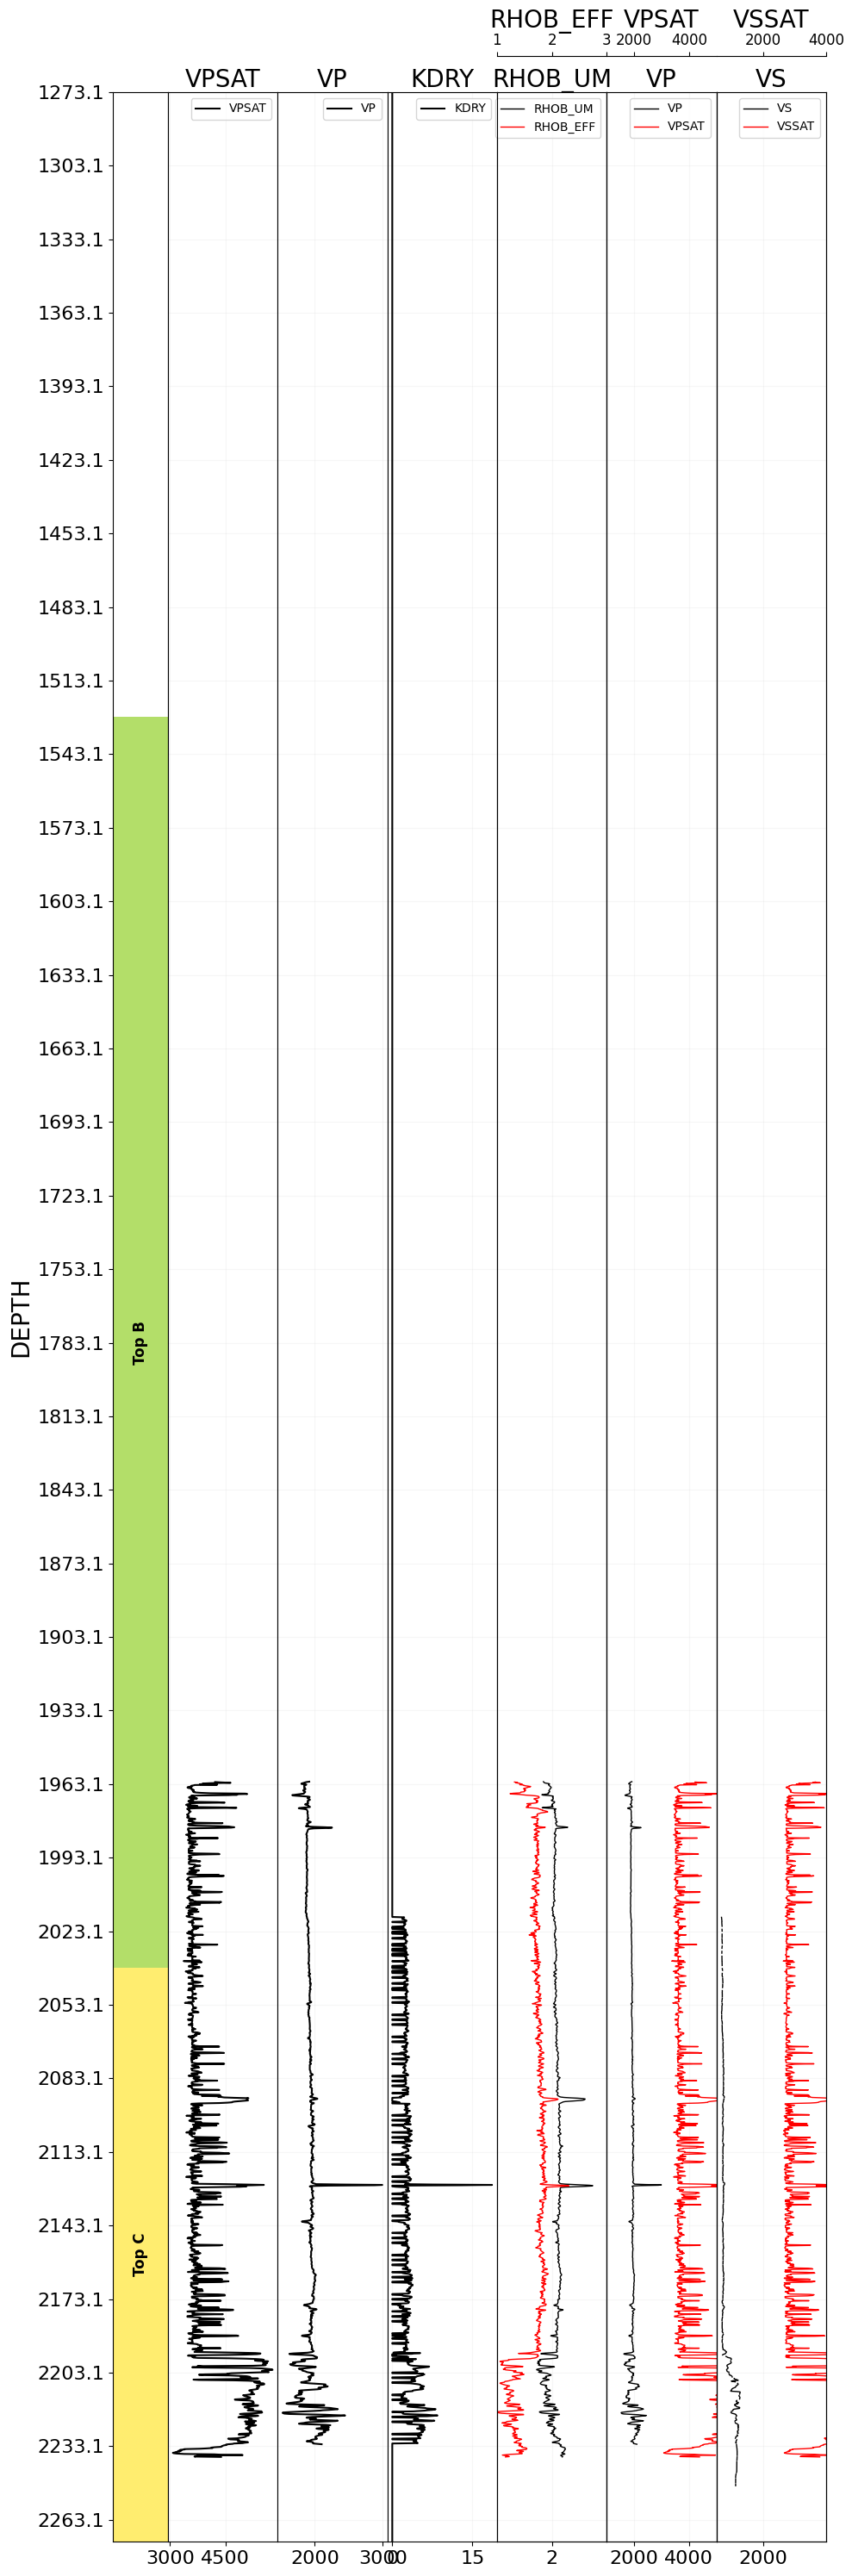

In [400]:
multi_log_plotter(figsize=(10, 30), depth_interval=30, plot_formation_tops=True, formation_alpha=1)

# Crossplot

In [236]:
# Crossplot configuration WITHOUT regression options
crossplot_config = {
    "CROSSPLOT": {
        "x_axis": {
            "log": 'RHOB_UM',          
            "color": "black",
            "scale": "linear",   
            "xlim": None  # Optional: auto-calculated if None
        },
        "y_axis": {
            "log": 'RHOB_EFF',           
            "color": "red",
            "scale": "linear",
            "ylim": None  # Optional: auto-calculated if None
        },
        "z_axis": {
            "log": 'SWWX_UM',           
            "scale": "linear",
            "zlim": (0, 1),
            "colormap": "gist_rainbow"
        },
        "title": "RHOB Cross Validation",
        "point_size": 40,
        "edgecolor": None,
        "alpha": 1
    }
}

In [288]:
def create_crossplot(df, config, show_regression=False, regression_color='k', 
                    regression_linewidth=2, show_statistics=False, 
                    statistics_position='upper left', statistics_fontsize=10, 
                    statistics_background_color='wheat', 
                    statistics_background_alpha=0.8, show_legend=True, 
                    legend_position='lower right'):
    """
    Create a crossplot with optional linear regression line and statistics
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the log data
    config : dict
        Crossplot configuration dictionary
    show_regression : bool
        Whether to show linear regression line (default: False)
    regression_color : str
        Color of regression line (default: 'k' - black)
    regression_linewidth : int
        Width of regression line (default: 2)
    show_statistics : bool
        Whether to show statistics box (default: False)
    statistics_position : str
        Position of stats box: "upper left", "upper right", "lower left", "lower right" (default: "upper left")
    statistics_fontsize : int
        Font size for statistics (default: 10)
    statistics_background_color : str
        Background color for stats box (default: "wheat")
    statistics_background_alpha : float
        Transparency of stats box (default: 0.8)
    show_legend : bool
        Whether to show legend for regression line (default: True)
    legend_position : str
        Position of legend (default: "lower right")
    """
    # Extract configuration
    plot_config = config["CROSSPLOT"]
    x_config = plot_config["x_axis"]
    y_config = plot_config["y_axis"]
    z_config = plot_config.get("z_axis")
    
    # Get data
    x = df[x_config["log"]].values
    y = df[y_config["log"]].values
    
    # Remove NaN values from both x and y for clean data
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_clean = x[mask]
    y_clean = y[mask]
    
    # Handle z-axis (color) if provided
    if z_config:
        z = df[z_config["log"]].values
        # Apply the same mask to z for consistent plotting
        if len(z) == len(mask):
            z_clean = z[mask]
        else:
            z_clean = z
        cmap = z_config.get("colormap", "viridis")
    else:
        z_clean = None
        cmap = None
    
    # Create figure
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    
    # Create scatter plot
    if z_clean is not None:
        sc = ax.scatter(
            x_clean, y_clean, 
            c=z_clean, 
            cmap=cmap, 
            s=plot_config["point_size"],
            edgecolor=plot_config["edgecolor"],
            alpha=plot_config["alpha"]
        )
        
        # Add colorbar if z is provided
        cbar = plt.colorbar(sc)
        cbar.set_label(z_config["log"], fontsize=14)
    else:
        # Single color scatter plot
        sc = ax.scatter(
            x_clean, y_clean, 
            color=x_config["color"],  # Use x-axis color if no z
            s=plot_config["point_size"],
            edgecolor=plot_config["edgecolor"],
            alpha=plot_config["alpha"]
        )
    
    # Initialize regression statistics
    regression_stats = None
    
    # Calculate and plot regression if requested
    if show_regression and len(x_clean) >= 2:
        # Calculate linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_clean, y_clean)
        r_squared = r_value ** 2
        
        # Create regression line points
        x_regression = np.array([np.nanmin(x_clean), np.nanmax(x_clean)])
        y_regression = intercept + slope * x_regression
        
        # Plot regression line
        ax.plot(x_regression, y_regression, 
                color=regression_color,
                linewidth=regression_linewidth,
                label='Linear Regression')
        
        # Calculate additional statistics
        y_pred = intercept + slope * x_clean
        residuals = y_clean - y_pred
        mse = np.mean(residuals ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(residuals))
        
        # Store regression statistics
        regression_stats = {
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_squared,
            'r_value': r_value,
            'p_value': p_value,
            'std_err': std_err,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'n_points': len(x_clean),
            'equation': f'y = {slope:.4f}x + {intercept:.4f}'
        }
        
        # Add statistics box if requested
        if show_statistics and regression_stats:
            # Prepare statistics text
            equation_text = regression_stats['equation']
            r2_text = f'R² = {regression_stats["r_squared"]:.4f}'
            n_text = f'n = {regression_stats["n_points"]}'
            
            # Add error statistics if desired (optional)
            # rmse_text = f'RMSE = {regression_stats["rmse"]:.4f}'
            # mae_text = f'MAE = {regression_stats["mae"]:.4f}'
            # stats_text = f'{equation_text}\n{r2_text}\n{rmse_text}\n{mae_text}\n{n_text}'
            
            stats_text = f'{equation_text}\n{r2_text}\n{n_text}'
            
            # Determine position based on configuration
            position = statistics_position.lower()
            if position == "upper left":
                x_pos, y_pos, va = 0.02, 0.98, 'top'
            elif position == "upper right":
                x_pos, y_pos, va = 0.98, 0.98, 'top'
            elif position == "lower left":
                x_pos, y_pos, va = 0.02, 0.02, 'bottom'
            elif position == "lower right":
                x_pos, y_pos, va = 0.98, 0.02, 'bottom'
            else:  # default to upper left
                x_pos, y_pos, va = 0.02, 0.98, 'top'
            
            # Add statistics text box
            ax.text(x_pos, y_pos, stats_text, transform=ax.transAxes,
                    fontsize=statistics_fontsize,
                    verticalalignment=va,
                    horizontalalignment='left' if 'left' in position else 'right',
                    bbox=dict(boxstyle='round', 
                             facecolor=statistics_background_color,
                             alpha=statistics_background_alpha))
        
        # Add legend if requested
        if show_legend:
            ax.legend(loc=legend_position, fontsize=12)
    
    # Set labels - Use log names from x_axis and y_axis configuration
    ax.set_xlabel(x_config["log"], fontsize=14)
    ax.set_ylabel(y_config["log"], fontsize=14)
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    
    # Set scales
    if x_config["scale"] == "log":
        ax.set_xscale('log')
    if y_config["scale"] == "log":
        ax.set_yscale('log')
    
    # Set limits
    if x_config.get("xlim") is not None:
        ax.set_xlim(x_config["xlim"])
    else:
        # Auto-set with 5% padding
        if len(x_clean) > 0:
            x_min, x_max = np.nanmin(x_clean), np.nanmax(x_clean)
            x_range = x_max - x_min
            if x_range > 0:
                ax.set_xlim(x_min - 0.05*x_range, x_max + 0.05*x_range)
    
    if y_config.get("ylim") is not None:
        ax.set_ylim(y_config["ylim"])
    else:
        # Auto-set with 5% padding
        if len(y_clean) > 0:
            y_min, y_max = np.nanmin(y_clean), np.nanmax(y_clean)
            y_range = y_max - y_min
            if y_range > 0:
                ax.set_ylim(y_min - 0.05*y_range, y_max + 0.05*y_range)
    
    # Add title
    ax.set_title(plot_config["title"], fontsize=14, fontweight='bold')
    
    # Grid settings
    ax.grid(which='major', linestyle='-', linewidth=0.5, color='gray')
    ax.grid(which='minor', linestyle=':', linewidth=0.5, color='black')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics to console if regression was calculated
    if regression_stats:
        print("=" * 60)
        print(f"CROSSPLOT STATISTICS: {plot_config['title']}")
        print("=" * 60)
        print(f"X-axis: {x_config['log']}")
        print(f"Y-axis: {y_config['log']}")
        if z_config:
            print(f"Z-axis: {z_config['log']}")
        print(f"Number of valid points: {regression_stats['n_points']}")
        print(f"Linear regression equation: {regression_stats['equation']}")
        print(f"R-squared (R²): {regression_stats['r_squared']:.4f}")
        print(f"P-value: {regression_stats['p_value']:.2e}")
        print(f"Standard error: {regression_stats['std_err']:.4f}")
        print(f"Mean Squared Error (MSE): {regression_stats['mse']:.4f}")
        print(f"Root Mean Squared Error (RMSE): {regression_stats['rmse']:.4f}")
        print(f"Mean Absolute Error (MAE): {regression_stats['mae']:.4f}")
        print("=" * 60)
    
    return regression_stats

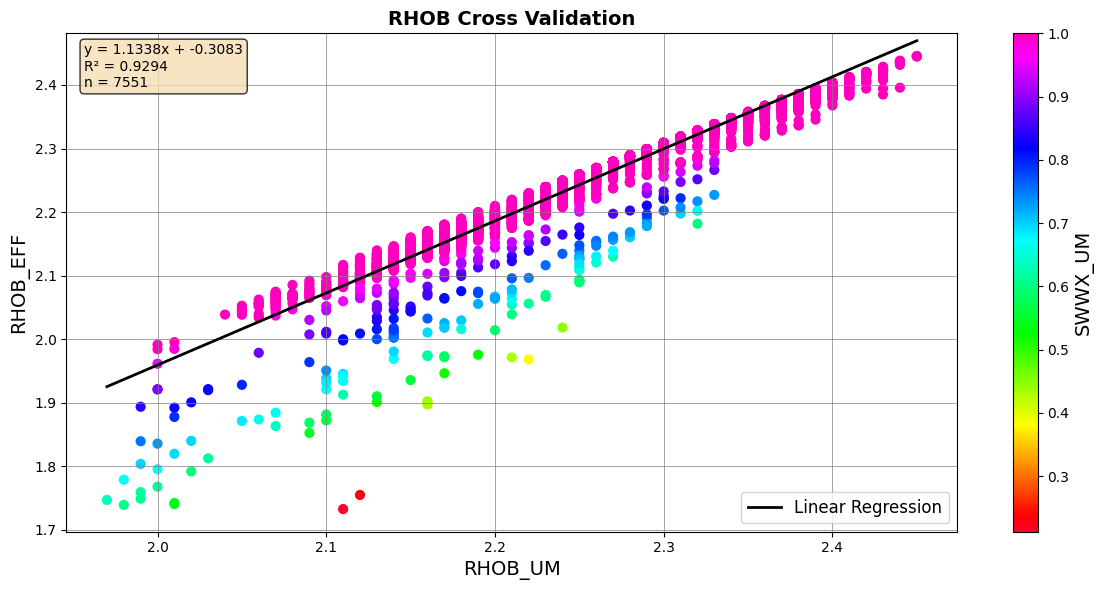

CROSSPLOT STATISTICS: RHOB Cross Validation
X-axis: RHOB_UM
Y-axis: RHOB_EFF
Z-axis: SWWX_UM
Number of valid points: 7551
Linear regression equation: y = 1.1338x + -0.3083
R-squared (R²): 0.9294
P-value: 0.00e+00
Standard error: 0.0036
Mean Squared Error (MSE): 0.0006
Root Mean Squared Error (RMSE): 0.0242
Mean Absolute Error (MAE): 0.0129


{'slope': np.float64(1.133798169842983),
 'intercept': np.float64(-0.308254771676165),
 'r_squared': np.float64(0.9293717203338119),
 'r_value': np.float64(0.964039273232067),
 'p_value': np.float64(0.0),
 'std_err': np.float64(0.003597374288540705),
 'mse': np.float64(0.0005851511609409149),
 'rmse': np.float64(0.024189897910923786),
 'mae': np.float64(0.012865923280936302),
 'n_points': 7551,
 'equation': 'y = 1.1338x + -0.3083'}

In [238]:
create_crossplot(df, crossplot_config,show_regression=True, show_statistics=True)